# Vega Lite Examples in Haskell - Maps (Geographic Displays)

The overview notebook - `VegaLiteGallery` - describes how 
[`hvega`](http://hackage.haskell.org/package/hvega)
is used to create Vega-Lite visualizations.

-----

## Table of Contents

This notebook represents the [Maps (Geographic Displays)](https://vega.github.io/vega-lite/examples/#maps-geographic-displays)
section of the [Vega-Lite example gallery](https://vega.github.io/vega-lite/examples/).

 - [Choropleth of unemployment rate per county](#Choropleth-of-unemployment-rate-per-county)
 - [One dot per zipcode in the U.S.](#One-dot-per-zipcode-in-the-U.S.)
 - [One dot per airport in the US overlayed on geoshape](#One-dot-per-airport-in-the-US-overlayed-on-geoshape)
 - [Rules (line segments) connecting SEA to every airport reachable via direct flight](#Rules-%28line-segments%29-connecting-SEA-to-every-airport-reachable-via-direct-flight)
 - [Three choropleths representing disjoint data from the same table](#Three-choropleths-representing-disjoint-data-from-the-same-table)
 - [U.S. state capitals overlayed on a map of the U.S.](#U.S.-state-capitals-overlayed-on-a-map-of-the-U.S.)
 - [Line drawn between airports in the U.S. simulating a flight itinerary](#Line-drawn-between-airports-in-the-U.S.-simulating-a-flight-itinerary)
 - [Income in the U.S. by state, faceted over income brackets](#Income-in-the-U.S.-by-state,-faceted-over-income-brackets)
 - [London Tube Lines](#London-Tube-Lines)


## Versions

The notebook was last run with the following versions of [`hvega`](https://hackage.haskell.org/package/hvega) and
related modules:

In [1]:
:!ghc-pkg latest ghc
:!ghc-pkg latest ihaskell
:!ghc-pkg latest hvega
:!ghc-pkg latest ihaskell-hvega

ghc-8.4.4

ihaskell-0.9.1.0

hvega-0.4.0.0

ihaskell-hvega-0.2.0.3

As to when it was last run, how about:

In [2]:
import Data.Time (getCurrentTime)
getCurrentTime

2019-09-04 13:02:33.847735323 UTC

## A note on version 0.4.0.0

The `hvega-0.4.0.0` release made a number of changes, including changing `PType` to `PrType` (in fact, all
the `ProjectionProperty` constructors were renamed to start with `Pr` rather than `P`).

## Set up

See the overview notebook for an explanation of this section (it provides code I use to compate the `hvega` output
to the specification given in the Vega-Lite gallery).

In [3]:
{-# LANGUAGE OverloadedStrings #-}

-- VegaLite uses these names
import Prelude hiding (filter, lookup, repeat)

import Graphics.Vega.VegaLite

-- IHaskell automatically imports this if the `ihaskell-vega` module is installed
-- import IHaskell.Display.Hvega

-- If you are viewing this in an IHaskell notebook rather than Jupyter Lab,
-- use the following to see the visualizations
--
-- vlShow = id

In [4]:
{-# LANGUAGE QuasiQuotes #-}

import qualified Data.ByteString.Lazy.Char8 as BL8
import qualified Data.HashMap.Strict as HM
import qualified Data.Set as S

import Data.Aeson (Value(Object), encode)
import Data.Aeson.QQ.Simple (aesonQQ)
import Control.Monad (forM_, unless, when)
import Data.Maybe (fromJust)
import System.Directory (removeFile)
import System.Process (readProcess, readProcessWithExitCode)

validate ::
  VLSpec       -- ^ The expected specification
  -> VegaLite  -- ^ The actual visualization
  -> IO ()
validate exp vl = 
  let got = fromVL vl
      put = putStrLn
  in if got == exp
      then put "Okay"
      else do
        let red = "\x1b[31m"
            def = "\x1b[0m"
            
            report m = put (red ++ m ++ def)
            
        report "The visualization and expected specification do not match."
        
        -- assume both objects
        let Object oexp = exp
            Object ogot = got
            kexp = S.fromList (HM.keys oexp)
            kgot = S.fromList (HM.keys ogot)
            kmiss = S.toList (S.difference kexp kgot)
            kextra = S.toList (S.difference kgot kexp)
            keys = S.toList (S.intersection kexp kgot)
            
        unless (null kmiss && null kextra) $ do
          put ""
          report "Keys are different:"
          unless (null kmiss)  $ put ("  Missing: " ++ show kmiss)
          unless (null kextra) $ put ("  Extra  : " ++ show kextra)

        -- this often creates an impressive amount of text for what is
        -- only a small change, which is why it is followed by a call
        -- to debug
        --
        forM_ keys $ \key ->
          let vexp = fromJust (HM.lookup key oexp)
              vgot = fromJust (HM.lookup key ogot)
          in when (vexp /= vgot) $ do
            put ""
            report ("Values are different for " ++ show key)
            put ("  Expected: " ++ show vexp)
            put ("  Found   : " ++ show vgot)
          
        putStrLn ""
        report "The field-level differences are:"
        debug_ exp vl


-- Rather than come up with a way to diff JSON here, rely on `jq` and the trusty
-- `diff` command. This is not written to be robust!
--
debug_ spec vl = do
  let tostr = BL8.unpack . encode
  
  expected <- readProcess "jq" [] (tostr spec)
  got <- readProcess "jq" [] (tostr (fromVL vl))

  let f1 = "expected.json"
      f2 = "got.json"
      
  writeFile f1 expected
  writeFile f2 got
  
  let diffOpts = ["--minimal", f1, f2]
  (_, diff, _) <- readProcessWithExitCode "diff" diffOpts ""
  putStrLn diff
  
  forM_ [f1, f2] removeFile

# Choropleth of unemployment rate per county


From https://vega.github.io/vega-lite/examples/geo_choropleth.html

In [5]:
geoChoroplethSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "width": 500,
  "height": 300,
  "data": {
    "url": "data/us-10m.json",
    "format": {
      "type": "topojson",
      "feature": "counties"
    }
  },
  "transform": [{
    "lookup": "id",
    "from": {
      "data": {
        "url": "data/unemployment.tsv"
      },
      "key": "id",
      "fields": ["rate"]
    }
  }],
  "projection": {
    "type": "albersUsa"
  },
  "mark": "geoshape",
  "encoding": {
    "color": {
      "field": "rate",
      "type": "quantitative"
    }
  }
}
|]

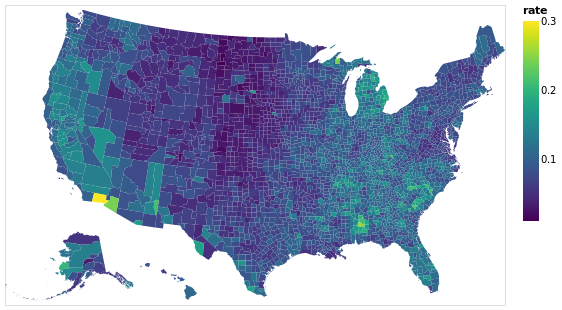

In [6]:
geoChoropleth =
    let dvals = dataFromUrl "data/us-10m.json"
                   [TopojsonFeature "counties"]
           
        trans = transform
                   . lookup "id"
                            (dataFromUrl "data/unemployment.tsv" [])
                            "id"
                            ["rate"]
                            
        proj = projection [PrType AlbersUsa]
        enc = encoding
                 . color [MName "rate", MmType Quantitative]
                 
    in toVegaLite [ width 500, height 300, dvals
                  , trans [], proj, mark Geoshape [], enc []]
       
vlShow geoChoropleth

In [7]:
validate geoChoroplethSpec geoChoropleth

Okay

Return to the [Table of Contents](#Table-of-Contents).

## One dot per zipcode in the U.S.

From https://vega.github.io/vega-lite/examples/geo_circle.html

In [8]:
geoCircleSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "width": 500,
  "height": 300,
  "data": {
    "url": "data/zipcodes.csv"
  },
  "transform": [{"calculate": "substring(datum.zip_code, 0, 1)", "as": "digit"}],
  "projection": {
    "type": "albersUsa"
  },
  "mark": "circle",
  "encoding": {
    "longitude": {
      "field": "longitude",
      "type": "quantitative"
    },
    "latitude": {
      "field": "latitude",
      "type": "quantitative"
    },
    "size": {"value": 1},
    "color": {"field": "digit", "type": "nominal"}
  }
}
|]

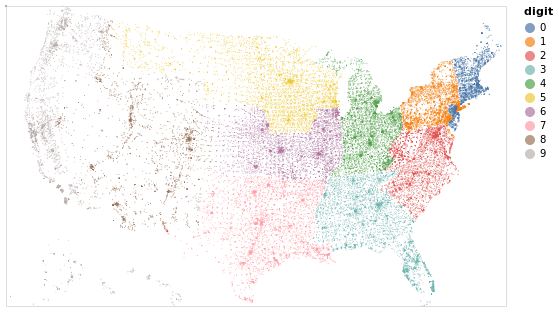

In [9]:
geoCircle =
    let dvals = dataFromUrl "data/zipcodes.csv"
           
        trans = transform
                   . calculateAs "substring(datum.zip_code, 0, 1)" "digit"
                            
        proj = projection [PrType AlbersUsa]
        enc = encoding
                 . position Longitude [PName "longitude", PmType Quantitative]
                 . position Latitude [PName "latitude", PmType Quantitative]
                 . size [MNumber 1]
                 . color [MName "digit", MmType Nominal]
                 
    in toVegaLite [ width 500, height 300, dvals []
                  , trans [], proj, mark Circle [], enc []]
       
vlShow geoCircle

In [10]:
validate geoCircleSpec geoCircle

Okay

Return to the [Table of Contents](#Table-of-Contents).

## One dot per airport in the US overlayed on geoshape

From https://vega.github.io/vega-lite/examples/geo_layer.html

In [11]:
geoLayerSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "width": 500,
  "height": 300,
  "layer": [
    {
      "data": {
        "url": "data/us-10m.json",
        "format": {
          "type": "topojson",
          "feature": "states"
        }
      },
      "projection": {
        "type": "albersUsa"
      },
      "mark": {
        "type": "geoshape",
        "fill": "lightgray",
        "stroke": "white"
      }
    },
    {
      "data": {
        "url": "data/airports.csv"
      },
      "projection": {
        "type": "albersUsa"
      },
      "mark": "circle",
      "encoding": {
        "longitude": {
          "field": "longitude",
          "type": "quantitative"
        },
        "latitude": {
          "field": "latitude",
          "type": "quantitative"
        },
        "size": {"value": 10},
        "color": {"value": "steelblue"}
      }
    }
  ]
}
|]

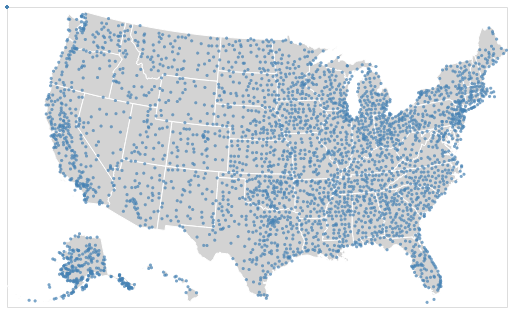

In [12]:
geoLayer =
    let dvals1 = dataFromUrl "data/us-10m.json"
                    [TopojsonFeature "states"]
                    
        dvals2 = dataFromUrl "data/airports.csv"
                            
        proj = projection [PrType AlbersUsa]
        enc = encoding
                 . position Longitude [PName "longitude", PmType Quantitative]
                 . position Latitude [PName "latitude", PmType Quantitative]
                 . size [MNumber 10]
                 . color [MString "steelblue"]
               
        lyr1 = asSpec [dvals1, proj, mark Geoshape [MFill "lightgray", MStroke "white"]]
        lyr2 = asSpec [dvals2 [], proj, mark Circle [], enc []]
           
    in toVegaLite [width 500, height 300, layer [lyr1, lyr2]]

vlShow geoLayer

In [13]:
validate geoLayerSpec geoLayer

Okay

Return to the [Table of Contents](#Table-of-Contents).

## Rules (line segments) connecting SEA to every airport reachable via direct flight

From https://vega.github.io/vega-lite/examples/geo_rule.html

`hvega` can not create the same specification, but it can create the same visualization
(the `lookupAs` transform can not create the syntax used in the specification, but we
can add a separate `transform` step to achieve the same result, as discussed at
https://github.com/gicentre/elm-vegalite/issues/14). This means that the `validate` output
below looks rather impressive!

In [14]:
geoRuleSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "width": 800,
  "height": 500,
  "layer": [
    {
      "data": {
        "url": "data/us-10m.json",
        "format": {
          "type": "topojson",
          "feature": "states"
        }
      },
      "projection": {
        "type": "albersUsa"
      },
      "mark": {
        "type": "geoshape",
        "fill": "lightgray",
        "stroke": "white"
      }
    },
    {
      "data": {
        "url": "data/airports.csv"
      },
      "projection": {
        "type": "albersUsa"
      },
      "mark": "circle",
      "encoding": {
        "longitude": {
          "field": "longitude",
          "type": "quantitative"
        },
        "latitude": {
          "field": "latitude",
          "type": "quantitative"
        },
        "size": {"value": 5},
        "color": {"value": "gray"}
      }
    },
    {
      "data": {
        "url": "data/flights-airport.csv"
      },
      "transform": [
        {"filter": {"field": "origin", "equal": "SEA"}},
        {
          "lookup": "origin",
          "from": {
            "data": {
              "url": "data/airports.csv"
            },
            "key": "iata",
            "fields": ["latitude", "longitude"]
          },
          "as": ["origin_latitude", "origin_longitude"]
        },
        {
          "lookup": "destination",
          "from": {
            "data": {
              "url": "data/airports.csv"
            },
            "key": "iata",
            "fields": ["latitude", "longitude"]
          },
          "as": ["dest_latitude", "dest_longitude"]
        }
      ],
      "projection": {
        "type": "albersUsa"
      },
      "mark": "rule",
      "encoding": {
        "longitude": {
          "field": "origin_longitude",
          "type": "quantitative"
        },
        "latitude": {
          "field": "origin_latitude",
          "type": "quantitative"
        },
        "longitude2": {
          "field": "dest_longitude",
          "type": "quantitative"
        },
        "latitude2": {
          "field": "dest_latitude",
          "type": "quantitative"
        }
      }
    }
  ]
}
|]

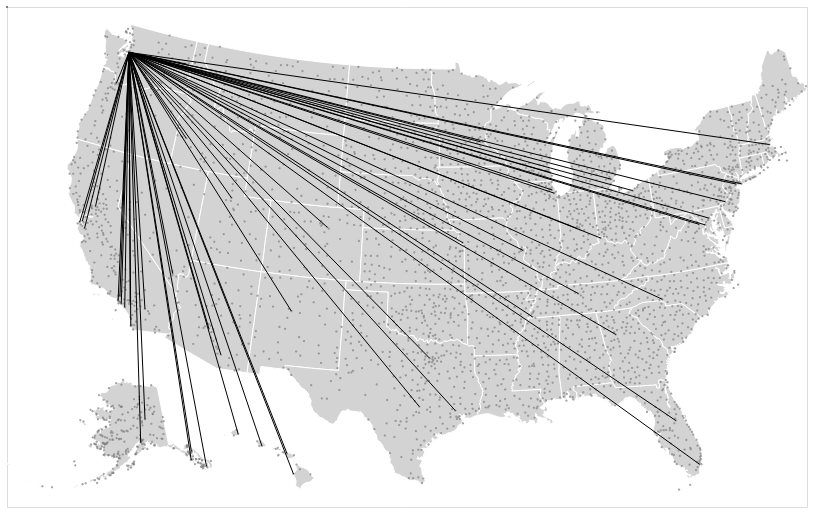

In [15]:
geoRule =
    let base = dataFromUrl "data/us-10m.json" [TopojsonFeature "states"]
        airports = dataFromUrl "data/airports.csv" []
        flights = dataFromUrl "data/flights-airport.csv" []

        proj = projection [PrType AlbersUsa]

        lon name = position Longitude [PName name, PmType Quantitative]
        lat name = position Latitude [PName name, PmType Quantitative]

        encAirports = encoding
                        . lon "longitude"
                        . lat "latitude"
                        . size [MNumber 5]
                        . color [MString "gray"]
        encFlights = encoding
                       . lon "origin.longitude"
                       . lat "origin.latitude"
                       . position Longitude2 [PName "destination.longitude"]
                       . position Latitude2 [PName "destination.latitude"]
 
 
        transFlights = transform
                         . filter (FEqual "origin" (Str "SEA"))
                         . lookupAs "origin" airports "iata" "origin"
                         . lookupAs "destination" airports "iata" "destination"

        lyrBase = asSpec [base, proj, mark Geoshape [MFill "lightgray", MStroke "white"]]
        lyrAirports = asSpec [airports, proj, mark Circle [], encAirports []]
        lyrFlights = asSpec [flights, encFlights [], transFlights [], proj, mark Rule []]
           
    in toVegaLite [width 800, height 500, layer [lyrBase, lyrAirports, lyrFlights]]

vlShow geoRule

As noted above, the `validate` output here does look worryingly large!

In [16]:
validate geoRuleSpec geoRule

The visualization and expected specification do not match.

Values are different for "layer"
  Expected: Array [Object (fromList [("mark",Object (fromList [("stroke",String "white"),("fill",String "lightgray"),("type",String "geoshape")])),("data",Object (fromList [("url",String "data/us-10m.json"),("format",Object (fromList [("feature",String "states"),("type",String "topojson")]))])),("projection",Object (fromList [("type",String "albersUsa")]))]),Object (fromList [("mark",String "circle"),("data",Object (fromList [("url",String "data/airports.csv")])),("projection",Object (fromList [("type",String "albersUsa")])),("encoding",Object (fromList [("color",Object (fromList [("value",String "gray")])),("size",Object (fromList [("value",Number 5.0)])),("latitude",Object (fromList [("field",String "latitude"),("type",String "quantitative")])),("longitude",Object (fromList [("field",String "longitude"),("type",String "quantitative")]))]))]),Object (fromList [("transform",Array [Object (fromL

Return to the [Table of Contents](#Table-of-Contents).

## Three choropleths representing disjoint data from the same table

From https://vega.github.io/vega-lite/examples/geo_repeat.html

In [17]:
geoRepeatSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "the population per state, engineers per state, and hurricanes per state",
  "repeat": {"row": ["population", "engineers", "hurricanes"]},
  "resolve": {
    "scale": {
      "color": "independent"
    }
  },
  "spec": {
    "width": 500,
    "height": 300,
    "data": {
      "url": "data/population_engineers_hurricanes.csv"
    },
    "transform": [
      {
        "lookup": "id",
        "from": {
          "data": {
            "url": "data/us-10m.json",
            "format": {
              "type": "topojson",
              "feature": "states"
            }
          },
          "key": "id"
        },
        "as": "geo"
      }
    ],
    "projection": {"type": "albersUsa"},
    "mark": "geoshape",
    "encoding": {
      "shape": {
        "field": "geo",
        "type": "geojson"
      },
      "color": {
        "field": {"repeat": "row"},
        "type": "quantitative"
      }
    }
  }
}
|]

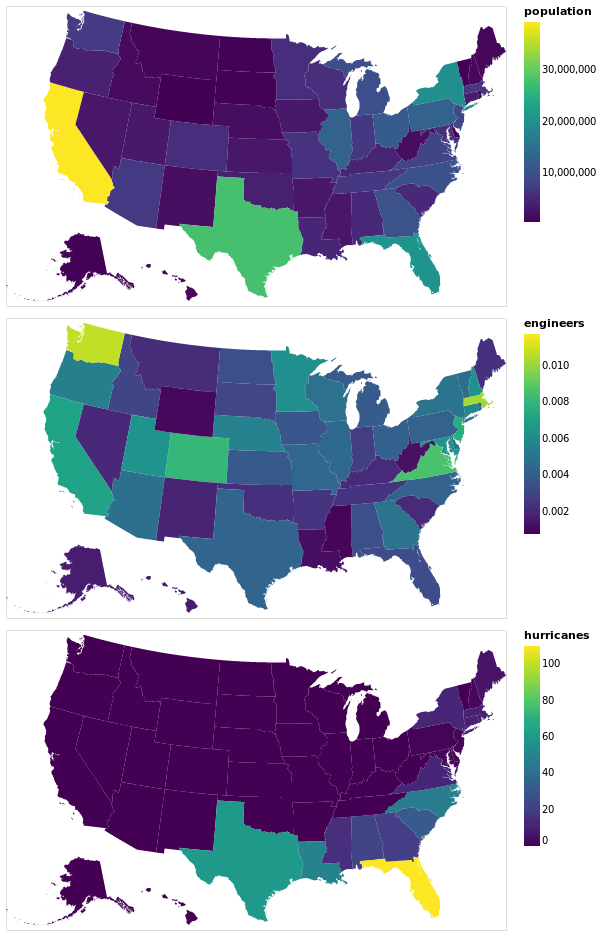

In [18]:
geoRepeat =
    let desc = "the population per state, engineers per state, and hurricanes per state"

        dvals1 = dataFromUrl "data/population_engineers_hurricanes.csv"
                    []
                    
        dvals2 = dataFromUrl "data/us-10m.json"
                    [TopojsonFeature "states"]
                                                    
        rp = [RowFields ["population", "engineers", "hurricanes"]]
        rsv = resolve
                 . resolution (RScale [(ChColor, Independent)])
           
        proj = projection [PrType AlbersUsa]
        enc = encoding
                 . shape [MName "geo", MmType GeoFeature]
                 . color [MRepeat Row, MmType Quantitative]
               
        trans = transform
                   . lookupAs "id" dvals2 "id" "geo"

        sp = asSpec [ width 500, height 300
                    , dvals1
                    , trans []
                    , proj
                    , mark Geoshape []
                    , enc []
                    ]
    in toVegaLite [description desc, repeat rp, rsv [], specification sp]

vlShow geoRepeat

In [19]:
validate geoRepeatSpec geoRepeat

Okay

Return to the [Table of Contents](#Table-of-Contents).

## U.S. state capitals overlayed on a map of the U.S.
html
From https://vega.github.io/vega-lite/examples/geo_text.html

In [20]:
geoTextSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "width": 800,
  "height": 500,
  "projection": {
    "type": "albersUsa"
  },
  "layer": [
    {
      "data": {
        "url": "data/us-10m.json",
        "format": {
          "type": "topojson",
          "feature": "states"
        }
      },
      "mark": {
        "type": "geoshape",
        "fill": "lightgray",
        "stroke": "white"
      }
    },
    {
      "data": {
        "url": "data/us-state-capitals.json"
      },
      "encoding": {
        "longitude": {
          "field": "lon",
          "type": "quantitative"
        },
        "latitude": {
          "field": "lat",
          "type": "quantitative"
        }
      },
      "layer": [{
        "mark": {
          "type": "circle",
          "color": "orange"
        }
      }, {
        "mark": {
          "type": "text",
          "dy": -10
        },
        "encoding": {
          "text": {"field": "city", "type": "nominal"}
        }
      }]
    }
  ]
}
|]

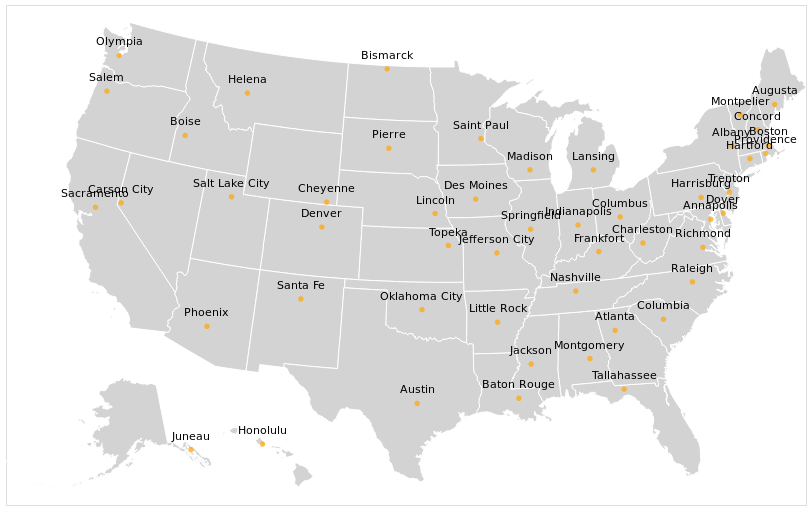

In [21]:
geoText =
    let dvals1 = dataFromUrl "data/us-10m.json"
                    [TopojsonFeature "states"]
                    
        dvals2 = dataFromUrl "data/us-state-capitals.json"
                    []
                    
        proj = projection [PrType AlbersUsa]
        enc2 = encoding
                  . position Longitude [PName "lon", PmType Quantitative]
                  . position Latitude [PName "lat", PmType Quantitative]    
        enc22 = encoding
                   . text [TName "city", TmType Nominal]
           
        lyr21 = asSpec [mark Circle [MColor "orange"]]
        lyr22 = asSpec [mark Text [MdY (-10)], enc22 []]
           
        lyr1 = asSpec [dvals1, mark Geoshape [MFill "lightgray", MStroke "white"]]
        lyr2 = asSpec [dvals2, enc2 [], layer [lyr21, lyr22]]
           
    in toVegaLite [width 800, height 500, proj, layer [lyr1, lyr2]]

vlShow geoText

In [22]:
validate geoTextSpec geoText

Okay

Return to the [Table of Contents](#Table-of-Contents).

## Line drawn between airports in the U.S. simulating a flight itinerary

From https://vega.github.io/vega-lite/examples/geo_line.html

In [23]:
geoLineSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "Line drawn between airports in the U.S. simulating a flight itinerary",
  "width": 800,
  "height": 500,
  "layer": [
    {
      "data": {
        "url": "data/us-10m.json",
        "format": {
          "type": "topojson",
          "feature": "states"
        }
      },
      "projection": {
        "type": "albersUsa"
      },
      "mark": {
        "type": "geoshape",
        "fill": "#eee",
        "stroke": "white"
      }
    },
    {
      "data": {
        "url": "data/airports.csv"
      },
      "projection": {
        "type": "albersUsa"
      },
      "mark": "circle",
      "encoding": {
        "longitude": {
          "field": "longitude",
          "type": "quantitative"
        },
        "latitude": {
          "field": "latitude",
          "type": "quantitative"
        },
        "size": {
          "value": 5
        },
        "color": {
          "value": "gray"
        }
      }
    },
    {
      "data": {
        "values": [
          {"airport": "SEA", "order": 1},
          {"airport": "SFO", "order": 2},
          {"airport": "LAX", "order": 3},
          {"airport": "LAS", "order": 4},
          {"airport": "DFW", "order": 5},
          {"airport": "DEN", "order": 6},
          {"airport": "ORD", "order": 7},
          {"airport": "JFK", "order": 8}
        ]
      },
      "transform": [
        {
          "lookup": "airport",
          "from": {
            "data": {
              "url": "data/airports.csv"
            },
            "key": "iata",
            "fields": [
              "latitude",
              "longitude"
            ]
          }
        }
      ],
      "projection": {
        "type": "albersUsa"
      },
      "mark": "line",
      "encoding": {
        "longitude": {
          "field": "longitude",
          "type": "quantitative"
        },
        "latitude": {
          "field": "latitude",
          "type": "quantitative"
        },
        "order": {
          "field": "order",
          "type": "ordinal"
        }
      }
    }
  ]
}
|]

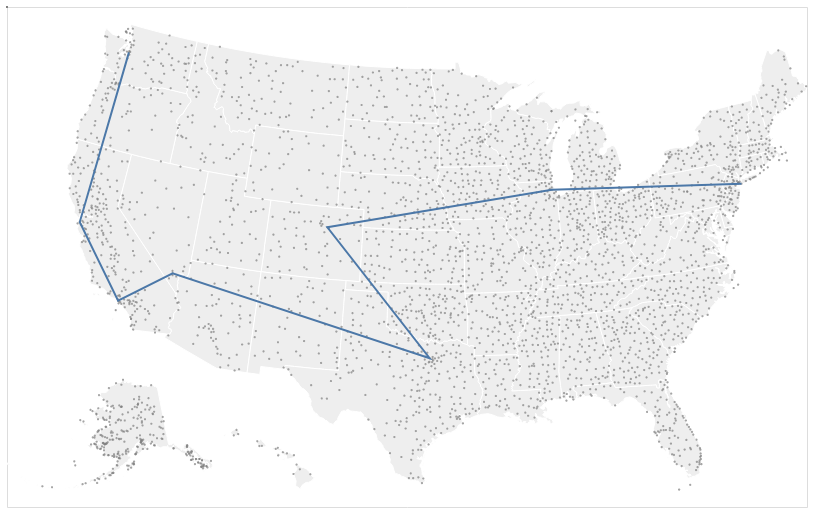

In [24]:
geoLine =
    let desc = "Line drawn between airports in the U.S. simulating a flight itinerary"

        dvals1 = dataFromUrl "data/us-10m.json" [TopojsonFeature "states"]
        dvals2 = dataFromUrl "data/airports.csv" []
        dvals3 = dataFromColumns []
                    . dataColumn "airport" (Strings ["SEA", "SFO", "LAX", "LAS", "DFW", "DEN", "ORD", "JFK"])
                    . dataColumn "order" (Numbers [1..8])
                                                        
        proj = projection [PrType AlbersUsa]
        enc2 = encoding
                  . position Longitude [PName "longitude", PmType Quantitative]
                  . position Latitude [PName "latitude", PmType Quantitative]
                  . size [MNumber 5]
                  . color [MString "gray"]
        enc3 = encoding
                  . position Longitude [PName "longitude", PmType Quantitative]
                  . position Latitude [PName "latitude", PmType Quantitative]
                  . order [OName "order", OmType Ordinal]
               
        trans = transform
                   . lookup "airport" dvals2 "iata" ["latitude", "longitude"]

        lyr1 = asSpec [dvals1, proj, mark Geoshape [MFill "#eee", MStroke "white"]]
        lyr2 = asSpec [dvals2, proj, mark Circle [], enc2 []]
        lyr3 = asSpec [dvals3 [], trans [], proj, mark Line [], enc3 []]
           
    in toVegaLite [description desc, width 800, height 500, layer [lyr1, lyr2, lyr3]]

vlShow geoLine

In [25]:
validate geoLineSpec geoLine

Okay

Return to the [Table of Contents](#Table-of-Contents).

## Income in the U.S. by state, faceted over income brackets

From https://vega.github.io/vega-lite/examples/geo_trellis.html

In [26]:
geoTrellisSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "width": 500,
  "height": 300,
  "data": {
    "url": "data/income.json"
  },
  "transform": [
    {
      "lookup": "id",
      "from": {
        "data": {
          "url": "data/us-10m.json",
          "format": {
            "type": "topojson",
            "feature": "states"
          }
        },
        "key": "id"
      },
      "as": "geo"
    }
  ],
  "projection": {"type": "albersUsa"},
  "mark": "geoshape",
  "encoding": {
    "shape": {"field": "geo", "type": "geojson"},
    "color": {"field": "pct", "type": "quantitative"},
    "row": {"field": "group", "type": "nominal"}
  }
}
|]

In [27]:
geoTrellis =
    let dvals1 = dataFromUrl "data/income.json" []
        dvals2 = dataFromUrl "data/us-10m.json" [TopojsonFeature "states"]
                                                    
        proj = projection [PrType AlbersUsa]
        enc = encoding
                 . shape [MName "geo", MmType GeoFeature]
                 . color [MName "pct", MmType Quantitative]
                 . row [FName "group", FmType Nominal]
               
        trans = transform
                   . lookupAs "id" dvals2 "id" "geo"

    in toVegaLite [width 500, height 300, dvals1, trans [], proj, mark Geoshape [], enc []]

vlShow geoTrellis

In [28]:
validate geoTrellisSpec geoTrellis

Okay

Return to the [Table of Contents](#Table-of-Contents).

## London Tube Lines

From https://vega.github.io/vega-lite/examples/geo_layer_line_london.html

In [29]:
geoLayerLineLondonSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "width": 700,
  "height": 500,
  "config": {
    "view": {
      "stroke": "transparent"
    }
  },
  "layer": [
    {
      "data": {
        "url": "data/londonBoroughs.json",
        "format": {
          "type": "topojson",
          "feature": "boroughs"
        }
      },
      "mark": {
        "type": "geoshape",
        "stroke": "white",
        "strokeWidth": 2
      },
      "encoding": {
        "color": {
          "value": "#eee"
        }
      }
    },
    {
      "data": {
        "url": "data/londonCentroids.json",
        "format": {
          "type": "json"
        }
      },
      "transform": [
        {
          "calculate": "indexof (datum.name,' ') > 0  ? substring(datum.name,0,indexof(datum.name, ' ')) : datum.name",
          "as": "bLabel"
        }
      ],
      "mark": "text",
      "encoding": {
        "longitude": {
          "field": "cx",
          "type": "quantitative"
        },
        "latitude": {
          "field": "cy",
          "type": "quantitative"
        },
        "text": {
          "field": "bLabel",
          "type": "nominal"
        },
        "size": {
          "value": 8
        },
        "opacity": {
          "value": 0.6
        }
      }
    },
    {
      "data": {
        "url": "data/londonTubeLines.json",
        "format": {
          "type": "topojson",
          "feature": "line"
        }
      },
      "mark": {
        "type": "geoshape",
        "filled": false,
        "strokeWidth": 2
      },
      "encoding": {
        "color": {
          "field": "id",
          "type": "nominal",
          "legend": {
            "title": null,
            "orient": "bottom-right",
            "offset": 0
          },
          "scale": {
            "domain": [
              "Bakerloo",
              "Central",
              "Circle",
              "District",
              "DLR",
              "Hammersmith & City",
              "Jubilee",
              "Metropolitan",
              "Northern",
              "Piccadilly",
              "Victoria",
              "Waterloo & City"
            ],
            "range": [
              "rgb(137,78,36)",
              "rgb(220,36,30)",
              "rgb(255,206,0)",
              "rgb(1,114,41)",
              "rgb(0,175,173)",
              "rgb(215,153,175)",
              "rgb(106,114,120)",
              "rgb(114,17,84)",
              "rgb(0,0,0)",
              "rgb(0,24,168)",
              "rgb(0,160,226)",
              "rgb(106,187,170)"
            ]
          }
        }
      }
    }
  ]
}
|]

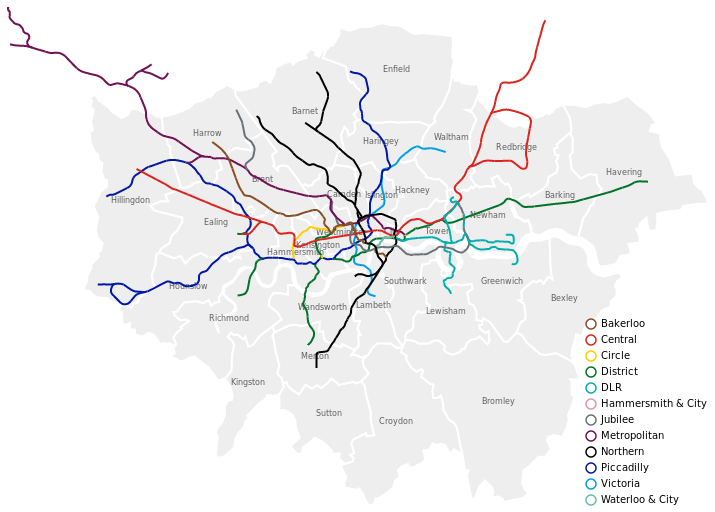

In [30]:
geoLayerLineLondon =
    let dvals1 = dataFromUrl "data/londonBoroughs.json"
                    [TopojsonFeature "boroughs"]
        
        -- hvega does not let you create a "format: {type: json}" element, which leads
        -- to a rather impressive-looking error from the validate command below, but
        -- it makes no difference to the visualization.
        --
        dvals2 = dataFromUrl "data/londonCentroids.json"
                    []
                    
        dvals3 = dataFromUrl "data/londonTubeLines.json"
                    [TopojsonFeature "line"]
                    
        -- in hvega 0.4.0.0, the constructors for ViewConfig were renamed so they
        -- all start with View
        conf = configure
                  . configuration (View [ViewStroke (Just "transparent")])

        scmap = categoricalDomainMap [ ("Bakerloo", "rgb(137,78,36)")
                                     , ("Central", "rgb(220,36,30)")
                                     , ("Circle", "rgb(255,206,0)")
                                     , ("District", "rgb(1,114,41)")
                                     , ("DLR", "rgb(0,175,173)")
                                     , ("Hammersmith & City", "rgb(215,153,175)")
                                     , ("Jubilee", "rgb(106,114,120)")
                                     , ("Metropolitan", "rgb(114,17,84)")
                                     , ("Northern", "rgb(0,0,0)")
                                     , ("Piccadilly", "rgb(0,24,168)")
                                     , ("Victoria", "rgb(0,160,226)")
                                     , ("Waterloo & City", "rgb(106,187,170)")
                                     ]
                         
        enc1 = encoding (color [MString "#eee"] [])
        enc2 = encoding
                  . position Longitude [PName "cx", PmType Quantitative]
                  . position Latitude [PName "cy",PmType Quantitative]
                  . text [TName "bLabel", TmType Nominal]
                  . size [MNumber 8]
                  . opacity [MNumber 0.6]

        -- Version 0.2 of hvega renamed the LegendOrientation symbols so that they start
        -- with LO. In the LOrient argument below, BottomRight was therefore changed to
        -- LOBottomRight.
        --
        -- Version 0.4 of heva added the LNoTitle constructor
        enc3 = encoding
                  . color [ MName "id", MmType Nominal
                          , MLegend [LNoTitle, LOrient LOBottomRight, LOffset 0]
                          , MScale scmap
                          ]
                  
        trans2 = transform
                    . calculateAs "indexof (datum.name,' ') > 0  ? substring(datum.name,0,indexof(datum.name, ' ')) : datum.name"
                                  "bLabel"

        lyr1 = asSpec [dvals1, mark Geoshape [MStroke "white", MStrokeWidth 2], enc1]
        lyr2 = asSpec [dvals2, trans2 [], mark Text [], enc2 []]
        lyr3 = asSpec [dvals3, mark Geoshape [MFilled False, MStrokeWidth 2], enc3 []]
           
    in toVegaLite [width 700, height 500, conf [], layer [lyr1, lyr2, lyr3]]

vlShow geoLayerLineLondon

In [31]:
validate geoLayerLineLondonSpec geoLayerLineLondon

The visualization and expected specification do not match.

Values are different for "layer"
  Expected: Array [Object (fromList [("mark",Object (fromList [("strokeWidth",Number 2.0),("stroke",String "white"),("type",String "geoshape")])),("data",Object (fromList [("url",String "data/londonBoroughs.json"),("format",Object (fromList [("feature",String "boroughs"),("type",String "topojson")]))])),("encoding",Object (fromList [("color",Object (fromList [("value",String "#eee")]))]))]),Object (fromList [("transform",Array [Object (fromList [("as",String "bLabel"),("calculate",String "indexof (datum.name,' ') > 0  ? substring(datum.name,0,indexof(datum.name, ' ')) : datum.name")])]),("mark",String "text"),("data",Object (fromList [("url",String "data/londonCentroids.json"),("format",Object (fromList [("type",String "json")]))])),("encoding",Object (fromList [("size",Object (fromList [("value",Number 8.0)])),("text",Object (fromList [("field",String "bLabel"),("type",String "nominal")])),("l

Return to the [Table of Contents](#Table-of-Contents).